# **Tiki Book Aspect-based Sentiment Analysis (ABSA)**



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Dataset

In [ ]:
import pandas as pd
# Đọc toàn bộ file và lấy tên cột từ dòng đầu tiên
with open(r'/content/drive/MyDrive/nlp-vabsa-main/small_tiki_comment.txt', 'r', encoding='utf-8') as f:
    lines = f.readlines()

header = lines[0].strip()  # Lấy tên cột từ dòng đầu tiên
lines = lines[1:]  # Xóa dòng đầu tiên

# Tạo DataFrame với cột 'content'
df = pd.DataFrame(lines, columns=[header])


In [ ]:
df.shape

(15137, 1)

In [ ]:
df.iloc[4].values

array(['Cảm ơn Tiki 🧡"\n'], dtype=object)

# Preprocessing

In [ ]:
import pandas as pd
import re
import string

# Đường dẫn file
file_path = r"/content/drive/MyDrive/nlp-vabsa-main/small_tiki_comment.txt"

# 1. Đọc dữ liệu từ file csv (có header là "content")
df = pd.read_csv(file_path, sep=",", quotechar='"', on_bad_lines='skip', engine='python')

# Loại bỏ các dòng có giá trị missing ở cột 'content'
df = df.dropna(subset=["content"])

# Các hàm chuẩn hóa

def normalize_money(sent):
    # Thay thế số + đơn vị (k, m, b) thành "giá"
    return re.sub(r'[0-9]+[.,0-9]*[kmb]', 'giá', sent, flags=re.IGNORECASE)

def normalize_hastag(sent):
    # Thay thế hashtag thành "tag"
    return re.sub(r'#+\w+', 'tag', sent)

def normalize_website(sent):
    # Thay thế URL thành "website"
    result = re.sub(r'http[s]?://(?:[a-zA-Z0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', 'website', sent)
    return re.sub(r'\w+(\.(com|vn|me))+((\/+([\.\w\_\-]+)?)+)?', 'website', result)

def nomalize_emoji(sent):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u200d"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\u3030"
        u"\ufe0f"
        u"\u2764"
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', sent)

def normalize_acronyms(sent):
    replace_list = {
        'ô kêi': ' ok ', 'okie': ' ok ', ' o kê ': ' ok ',
        'okey': ' ok ', 'ôkê': ' ok ', 'oki': ' ok ', ' oke ':  ' ok ',
        'okay':' ok ','okê':' ok ', ' tks ':' cám ơn ', 'thks':' cám ơn ',
        'thanks':' cám ơn ', 'ths':' cám ơn ', 'thank':' cám ơn ',
        '⭐':'star ', '*':'star ', '🌟':'star ', '🎉':' tích cực ',
        'kg ':' không ','not':' không ',' kh ':' không ','kô':' không ',
        'hok':' không ',' kp ':' không phải ',' ko ':' không ',' k ':' không ',
        'khong':' không ', 'he he':' tích cực ','hehe':' tích cực ',
        'hihi':' tích cực ', 'haha':' tích cực ', 'hjhj':' tích cực ',
        ' lol ':' tiêu cực ',' cc ':' tiêu cực ','cute':' dễ thương ',
        'huhu':' tiêu cực ', ' vs ':' với ', 'wa':' quá ', 'wá':' quá',
        'j':' gì ', 'sz ':' cỡ ', 'size':' cỡ ', 'đx ':' được ',
        'dk':' được ', 'dc':' được ', 'đk':' được ', 'đc':' được ',
        'authentic':' chuẩn chính hãng ','auth ':' chuẩn chính hãng ',
        'thick':' tích cực ', 'store':' cửa hàng ', 'shop':' cửa hàng ',
        'sp':' sản phẩm ', 'gud':' tốt ','god':' tốt ','wel done':' tốt ',
        'good':' tốt ', 'sấu':' xấu ','gut':' tốt ', ' tot ':' tốt ',
        ' nice ':' tốt ', 'perfect':'rất tốt', 'bt':' bình thường ',
        'time':' thời gian ', 'qá':' quá ', ' ship ':' giao hàng ',
        ' m ':' mình ', ' mik ':' mình ', 'ể':'ể', 'product':'sản phẩm',
        'quality':'chất lượng','chat':' chất ', 'excelent':'hoàn hảo',
        'bad':'tệ','fresh':' tươi ','sad':' tệ ', 'date':' hạn sử dụng ',
        'hsd':' hạn sử dụng ','quickly':' nhanh ', 'quick':' nhanh ',
        'fast':' nhanh ','delivery':' giao hàng ',' síp ':' giao hàng ',
        'beautiful':' đẹp tuyệt vời ', ' tl ':' trả lời ', ' r ':' rồi ',
        ' shopE ':' cửa hàng ',' order ':' đặt hàng ', 'chất lg':' chất lượng ',
        ' sd ':' sử dụng ',' dt ':' điện thoại ',' nt ':' nhắn tin ',
        ' tl ':' trả lời ',' sài ':' xài ','bjo':' bao giờ ','thik':' thích ',
        ' sop ':' cửa hàng ', ' fb ':' facebook ', ' face ':' facebook ',
        ' very ':' rất ','quả ng ':' quảng  ','dep':' đẹp ',' xau ':' xấu ',
        'delicious':' ngon ','hàg':' hàng ','qủa':' quả ','iu':' yêu ',
        'fake':' giả mạo ', 'trl':'trả lời', '><':' tích cực ',
        ' por ':' tệ ',' poor ':' tệ ', 'ib':' nhắn tin ', 'rep':' trả lời ',
        'fback':' feedback ','fedback':' feedback '
    }
    text = sent
    for k, v in replace_list.items():
        text = text.replace(k, v)
    return text

def normalize(sent):
    result = normalize_money(sent)
    result = normalize_hastag(result)
    result = normalize_website(result)
    result = nomalize_emoji(result)
    result = normalize_acronyms(result)
    result = result.lower()
    # Loại bỏ dấu câu, thay thế nhiều khoảng trắng bằng 1 khoảng trắng
    result = result.translate(str.maketrans(string.punctuation, ' ' * len(string.punctuation)))
    result = re.sub(r'\s+', ' ', result).strip()
    return result

# Áp dụng chuẩn hóa cho cột 'content'
df['content_normalized'] = df['content'].apply(normalize)

# Kiểm tra kết quả
print(df[['content', 'content_normalized']].head())

# Nếu muốn lưu ra file mới
df.to_csv('/content/drive/MyDrive/nlp-vabsa-main/small_tiki_comment_normalized.csv', index=False)


                                             content  \
0  Có những người bước đến, họ lấp đầy hạnh phúc ...   
1  Thấy nhiều bạn chê tiki gói hàng quá, may sao ...   
2  Bìa cực xinh, tiki giao hàng nhanh, sách không...   
3  Sách lúc nhận hình thức rất ổn, không cong vên...   
4  Một cuốn sách rất đáng đọc về tình yêu thương ...   

                                  content_normalized  
0  có những người bước đến họ lấp đầy hạnh phúc v...  
1  thấy nhiều bạn chê tiki gói hàng quá may sao h...  
2  bìa cực xinh tiki giao hàng nhanh sách không b...  
3  sách lúc nhận hình thức rất ổn không cong vênh...  
4  một cuốn sách rất đáng đọc về tình yêu thương ...  


In [ ]:
!pip install underthesea

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 78.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.0 MB/s eta 0:00:00


In [ ]:
!pip install -q vncorenlp sentence-transformers pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 19.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 71.0 MB/s eta 0:00:00


# Aspects Extraction

In [ ]:
# Tải mô hình VnCoreNLP
import os
vncorenlp_path = 'vncorenlp/VnCoreNLP-1.1.1.jar'
if not os.path.exists(vncorenlp_path):
    os.makedirs('vncorenlp', exist_ok=True)
    !wget -q -O {vncorenlp_path} https://github.com/vncorenlp/VnCoreNLP/releases/download/v1.1.1/VnCoreNLP-1.1.1.jar

# IMPORT THƯ VIỆN
from vncorenlp import VnCoreNLP
from sentence_transformers import SentenceTransformer, util
import pandas as pd
import re

# KHỞI TẠO MODELS
try:
    rdrsegmenter = VnCoreNLP(vncorenlp_path, annotators="wseg", max_heap_size='-Xmx1g', quiet=True)
    print("VnCoreNLP khởi tạo thành công.")
except Exception as e:
    print(f"Lỗi khi khởi tạo VnCoreNLP: {e}")

try:
    model = SentenceTransformer('VoVanPhuc/sup-SimCSE-VietNamese-phobert-base')
    print("Sentence-BERT model đã tải thành công.")
except Exception as e:
    print(f"Lỗi tải SentenceTransformer model: {e}")

# DANH SÁCH ASPECT
aspect_to_vietnamese = {
    "BOOK#GENERAL": "sách nói chung",
    "BOOK#PRICE": "giá sách",
    "BOOK#QUALITY": "chất lượng sách",
    "BOOK#CONTENT": "nội dung sách",
    "BOOK#FORMAT": "hình thức sách",
    "BOOK#READER_EXPERIENCE": "trải nghiệm người đọc",
    "BOOK#RECOMMENDATION": "khuyến nghị sách",
    "DELIVERY#SERVICE": "dịch vụ giao hàng",
    "SELLER#SERVICE": "dịch vụ người bán"
}

aspect_texts = list(aspect_to_vietnamese.values())
aspect_embeddings = model.encode(aspect_texts, convert_to_tensor=True)

# HÀM TIỀN XỬ LÝ & TRÍCH XUẤT
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\sáàảãạăắằẳẵặâấầẩẫậđéèẻẽẹêếềểễệíìỉĩịóòỏõọôốồổỗộơớờởỡợúùủũụưứừửữựýỳỷỹỵ!\.,;?:\'"\(\)\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def split_sentences(text):
    try:
        return [' '.join(sent) for sent in rdrsegmenter.tokenize(text)]
    except:
        return [text]

def extract_present_aspects_paragraph(paragraph, threshold=0.3):
    if not paragraph or pd.isna(paragraph):
        return []

    cleaned = clean_text(paragraph)
    sentences = split_sentences(cleaned)
    found_aspects = set()

    for sentence in sentences:
        if not sentence.strip():
            continue
        try:
            sent_embedding = model.encode(sentence, convert_to_tensor=True)
            cosine_scores = util.cos_sim(sent_embedding, aspect_embeddings)[0]
            for i, score in enumerate(cosine_scores):
                if score >= threshold:
                    found_aspects.add(list(aspect_to_vietnamese.keys())[i])
        except Exception as e:
            print(f"Lỗi xử lý câu: {sentence}, lỗi: {e}")
            continue

    return list(found_aspects)


# ĐỌC DỮ LIỆU

input_path = '/content/drive/MyDrive/nlp-vabsa-main/small_tiki_comment_normalized.csv'

if not os.path.exists(input_path):
    print(f"Không tìm thấy file tại {input_path}")
    df = pd.DataFrame({'content': []})
else:
    try:
        df = pd.read_csv(input_path)
        print(f"Đã tải dữ liệu từ: {input_path}")
    except Exception as e:
        print(f"Lỗi đọc file: {e}")
        df = pd.DataFrame({'content': []})


# ÁP DỤNG TRÍCH XUẤT ASPECT
if not df.empty:
    print("Đang tiến hành trích xuất khía cạnh...")
    df['detected_aspects'] = df['content'].apply(lambda x: extract_present_aspects_paragraph(str(x)))
    print("Hoàn thành trích xuất.")
else:
    print("Dữ liệu rỗng. Không thực hiện trích xuất.")

# LƯU KẾT QUẢ
output_path = "/content/drive/MyDrive/nlp-vabsa-main/Tiki_books_aspect_extracted_vncorenlp.csv"
if not df.empty:
    try:
        df.to_csv(output_path, index=False)
        print(f"Đã lưu kết quả vào: {output_path}")
    except Exception as e:
        print(f"Lỗi khi lưu file: {e}")
else:
    print("Không lưu vì dataframe rỗng.")

# XEM MẪU KẾT QUẢ
if not df.empty:
    print(df[['content', 'detected_aspects']].head())
else:
    print("Không có dữ liệu hiển thị.")


Lỗi khi khởi tạo VnCoreNLP: HTTPConnectionPool(host='127.0.0.1', port=56263): Max retries exceeded with url: /annotators (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7b9b201fb3d0>: Failed to establish a new connection: [Errno 111] Connection refused'))


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/731 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/270 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/17.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Sentence-BERT model đã tải thành công.
Đã tải dữ liệu từ: /content/drive/MyDrive/nlp-vabsa-main/small_tiki_comment_normalized.csv
Đang tiến hành trích xuất khía cạnh...
Hoàn thành trích xuất.
Đã lưu kết quả vào: /content/drive/MyDrive/nlp-vabsa-main/Tiki_books_aspect_extracted_vncorenlp.csv
                                             content  \
0  Có những người bước đến, họ lấp đầy hạnh phúc ...   
1  Thấy nhiều bạn chê tiki gói hàng quá, may sao ...   
2  Bìa cực xinh, tiki giao hàng nhanh, sách không...   
3  Sách lúc nhận hình thức rất ổn, không cong vên...   
4  Một cuốn sách rất đáng đọc về tình yêu thương ...   

                                    detected_aspects  
0  [BOOK#READER_EXPERIENCE, BOOK#QUALITY, BOOK#GE...  
1  [BOOK#FORMAT, BOOK#READER_EXPERIENCE, BOOK#PRI...  
2  [BOOK#FORMAT, BOOK#READER_EXPERIENCE, BOOK#PRI...  
3  [BOOK#FORMAT, BOOK#READER_EXPERIENCE, BOOK#PRI...  
4  [BOOK#FORMAT, BOOK#READER_EXPERIENCE, BOOK#PRI...  


# Sentiment Labelling

In [ ]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import ast
import math # Import math for ceiling calculation

# Load tokenizer và model sentiment
checkpoint = "mr4/phobert-base-vi-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

# Chọn device (GPU nếu có)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()  # Chế độ eval không train

# Đọc dữ liệu
file_path = "/content/drive/MyDrive/nlp-vabsa-main/Tiki_books_aspect_extracted_vncorenlp.csv"
df = pd.read_csv(file_path)

# Đảm bảo cột 'detected_aspects' là list
df['detected_aspects'] = df['detected_aspects'].apply(
    lambda x: ast.literal_eval(str(x)) if pd.notna(x) and x != "nan" else []
)

# Tạo list chứa các input combined (text + aspect)
combined_inputs = []
content_list = []
aspect_list = []

for index, row in df.iterrows():
    text = row['content']
    aspects = row['detected_aspects']
    if not aspects:
        continue
    for aspect in aspects:
        combined_input = f"Văn bản: {text} | Khía cạnh: {aspect}"
        combined_inputs.append(combined_input)
        content_list.append(text)
        aspect_list.append(aspect)

# Define batch size for inference
batch_size = 32 # You can adjust this value based on your GPU memory

# Calculate the number of batches
num_batches = math.ceil(len(combined_inputs) / batch_size)

results = []

print(f"Processing {len(combined_inputs)} inputs in {num_batches} batches of size {batch_size}")

# Process data in batches
for i in range(num_batches):
    start_index = i * batch_size
    end_index = min((i + 1) * batch_size, len(combined_inputs))
    batch_inputs_text = combined_inputs[start_index:end_index]
    batch_content = content_list[start_index:end_index]
    batch_aspect = aspect_list[start_index:end_index]

    # Tokenize batch
    inputs = tokenizer(
        batch_inputs_text,
        padding=True,
        truncation=True,
        return_tensors="pt"
    ).to(device)

    # Dự đoán batch
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)

    # Collect results for the batch
    for j, score in enumerate(probs):
        predicted_label = torch.argmax(score).item()
        results.append({
            "content": batch_content[j],
            "aspect": batch_aspect[j],
            "sentiment_label": predicted_label,
            "score_positive": score[2].item(),
            "score_neutral": score[1].item(),
            "score_negative": score[0].item()
        })

# Chuyển thành DataFrame và lưu
results_df = pd.DataFrame(results)
output_path = "/content/drive/MyDrive/nlp-vabsa-main/Tiki_books_aspect_sentiment_labeled.csv"
results_df.to_csv(output_path, index=False, encoding='utf-8-sig', float_format='%.4f')

print("Đã lưu kết quả sentiment (có nhãn dạng số) vào:", output_path)
print(results_df.head()) # Use print instead of display in scripts

tokenizer_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/22.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/993 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/540M [00:00<?, ?B/s]

Processing 67938 inputs in 2124 batches of size 32


In [ ]:
results_df.info()

In [3]:
import pandas as pd

# Đọc lại kết quả đã lưu
df = pd.read_csv("/content/drive/MyDrive/nlp-vabsa-main/Tiki_books_aspect_sentiment_labeled.csv")

# Đếm số lượng cảm xúc theo từng aspect
summary = df.groupby(["aspect", "sentiment_label"]).size().unstack(fill_value=0)

# Đổi tên cột để hiển thị nhãn rõ ràng hơn
summary.columns = ['0: negative', '1: neutral', '2: positive']

# In kết quả
print(summary)


                        0: negative  1: neutral  2: positive
aspect                                                      
BOOK#CONTENT                   1428        6607          186
BOOK#FORMAT                    1253        6570          130
BOOK#GENERAL                   1348        6443          148
BOOK#PRICE                     1295        6301          154
BOOK#QUALITY                   1361        6820          161
BOOK#READER_EXPERIENCE         1352        6251          156
BOOK#RECOMMENDATION            1251        6777          114
DELIVERY#SERVICE                738        3519           79
SELLER#SERVICE                 1221        6164          111


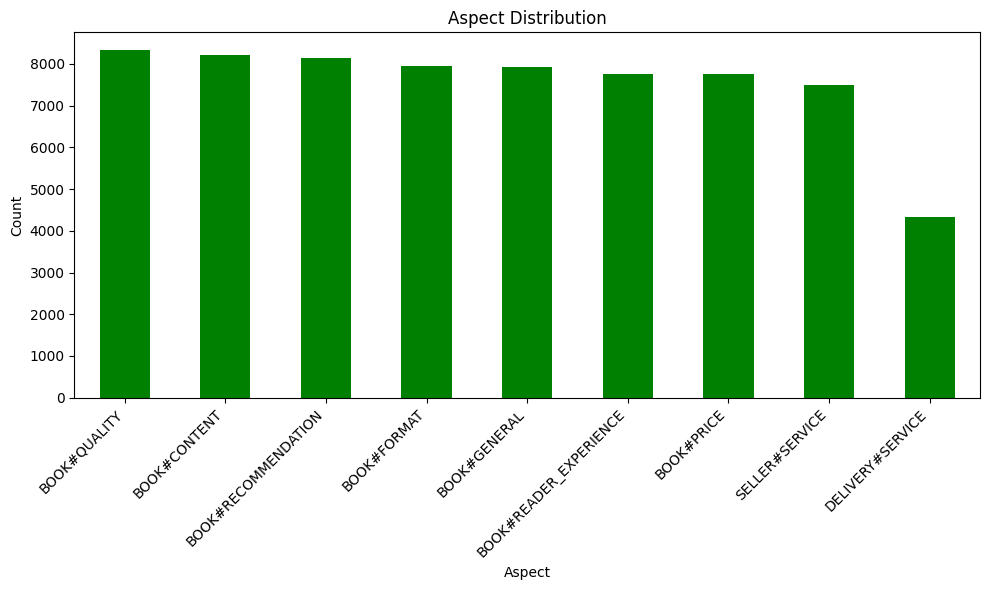

In [4]:
import matplotlib.pyplot as plt

# Đếm số lần xuất hiện của từng aspect
aspect_counts = df['aspect'].value_counts()

# Vẽ biểu đồ bar
plt.figure(figsize=(10, 6))
aspect_counts.plot(kind='bar', color='green')
plt.title("Aspect Distribution")
plt.xlabel("Aspect")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


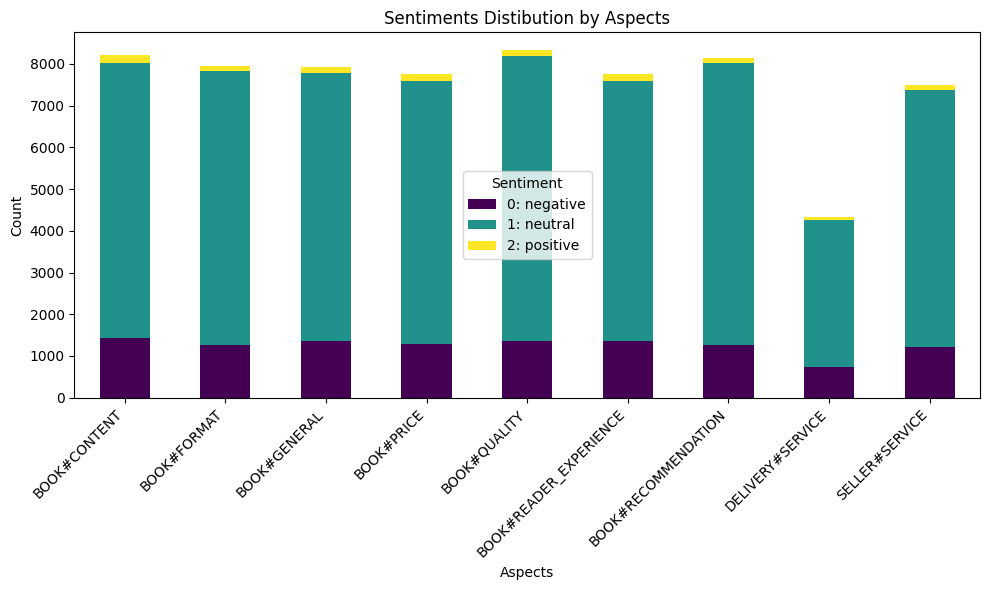

In [9]:
import matplotlib.pyplot as plt

# Plot stacked bar chart
summary.plot(kind="bar", stacked=True, figsize=(10, 6), colormap="viridis")
plt.title("Sentiments Distibution by Aspects")
plt.xlabel("Aspects")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()


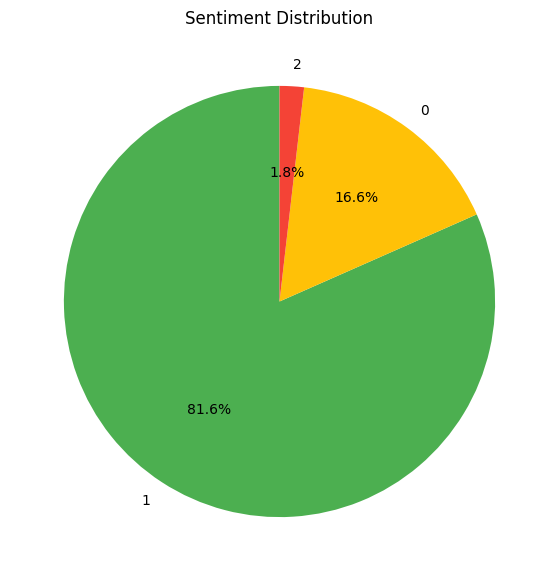

In [10]:
import matplotlib.pyplot as plt

# Count the occurrences of each sentiment
sentiment_counts = df['sentiment_label'].value_counts()

# Plot the pie chart
plt.figure(figsize=(7, 7))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90, colors=['#4CAF50', '#FFC107', '#F44336'])
plt.title("Sentiment Distribution")
plt.show()


# Training Preparation

In [5]:
df = pd.read_csv('/content/drive/MyDrive/nlp-vabsa-main/Tiki_books_aspect_sentiment_labeled.csv')
df

,content,aspect,sentiment_label,score_positive,score_neutral,score_negative
0,"Có những người bước đến, họ lấp đầy hạnh phúc ...",BOOK#QUALITY,1,0.2042,0.7270,0.0689
1,"Có những người bước đến, họ lấp đầy hạnh phúc ...",BOOK#GENERAL,1,0.2042,0.7270,0.0689
2,"Có những người bước đến, họ lấp đầy hạnh phúc ...",BOOK#READER_EXPERIENCE,1,0.2042,0.7270,0.0689
3,"Thấy nhiều bạn chê tiki gói hàng quá, may sao ...",BOOK#GENERAL,1,0.0433,0.9305,0.0263
4,"Thấy nhiều bạn chê tiki gói hàng quá, may sao ...",BOOK#RECOMMENDATION,1,0.0369,0.9407,0.0223
...,...,...,...,...,...,...
67933,"giao hàng nhanh, sách đẹp và mới.",BOOK#FORMAT,1,0.0051,0.9929,0.0020
67934,"giao hàng nhanh, sách đẹp và mới.",BOOK#QUALITY,1,0.0052,0.9929,0.0019
67935,"giao hàng nhanh, sách đẹp và mới.",SELLER#SERVICE,1,0.0051,0.9929,0.0020
67936,"giao hàng nhanh, sách đẹp và mới.",BOOK#PRICE,1,0.0052,0.9929,0.0019


In [6]:
df_train = df.drop(columns=['score_positive', 'score_neutral', 'score_negative'])


In [7]:
df_train.to_csv('/content/drive/MyDrive/nlp-vabsa-main/train_data.csv', index=False)
df = pd.read_csv('/content/drive/MyDrive/nlp-vabsa-main/train_data.csv')
df

,content,aspect,sentiment_label
0,"Có những người bước đến, họ lấp đầy hạnh phúc ...",BOOK#QUALITY,1
1,"Có những người bước đến, họ lấp đầy hạnh phúc ...",BOOK#GENERAL,1
2,"Có những người bước đến, họ lấp đầy hạnh phúc ...",BOOK#READER_EXPERIENCE,1
3,"Thấy nhiều bạn chê tiki gói hàng quá, may sao ...",BOOK#GENERAL,1
4,"Thấy nhiều bạn chê tiki gói hàng quá, may sao ...",BOOK#RECOMMENDATION,1
...,...,...,...
67933,"giao hàng nhanh, sách đẹp và mới.",BOOK#FORMAT,1
67934,"giao hàng nhanh, sách đẹp và mới.",BOOK#QUALITY,1
67935,"giao hàng nhanh, sách đẹp và mới.",SELLER#SERVICE,1
67936,"giao hàng nhanh, sách đẹp và mới.",BOOK#PRICE,1


# Sentiment Classification using VinAI-Phobert

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 1. Đọc dữ liệu
df = pd.read_csv('/content/drive/MyDrive/nlp-vabsa-main/train_data.csv')

# 2. Loại bỏ các dòng thiếu và chỉ giữ nhãn 0,1,2
df = df.dropna(subset=["content", "aspect", "sentiment_label"])
df = df[df["sentiment_label"].isin([0, 1, 2])]

# 3. Tạo cột kết hợp content + aspect
df['text_with_aspect'] = df.apply(
    lambda row: f"Văn bản: {row['content']} | Khía cạnh: {row['aspect']}",
    axis=1
)

# 4. Chuẩn bị X và y
X = df['text_with_aspect']
y = df['sentiment_label']

# 5. Tách train/test với stratify để giữ tỷ lệ nhãn
train_texts, test_texts, train_labels, test_labels = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y # để cho số lượng nhãn có tỷ lệ cân bằng giúp mô hình ko bị thiên lệch (nhưng dữ liệu đang bị lệch)
)

# 6. (Tuỳ chọn) Chuyển về list nếu cần cho bước tokenization
train_texts = train_texts.tolist()
test_texts  = test_texts.tolist()
train_labels = train_labels.tolist()
test_labels  = test_labels.tolist()

# Kiểm tra kích thước
print(f"Train samples: {len(train_texts)}, Test samples: {len(test_texts)}")
print("Class distribution in train:", pd.Series(train_labels).value_counts(normalize=True).to_dict())
print("Class distribution in test :", pd.Series(test_labels).value_counts(normalize=True).to_dict())


Train samples: 54350, Test samples: 13588
Class distribution in train: {1: 0.8162097516099356, 0: 0.16555657773689053, 2: 0.018233670653173873}
Class distribution in test : {1: 0.8162349131586694, 0: 0.16551368854871945, 2: 0.01825139829261113}


In [9]:
# Gọi mô hình vinai-phobert
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

# gọi đối tượng tokenizer để chuyển đổi văn bản thành dạng mã hóa (token IDs). Dữ liệu sẽ được chuyển đổi thành các token mà mô hình có thể hiểu.
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)


## truncation=True: Nếu văn bản quá dài, nó sẽ được cắt ngắn để đảm bảo độ dài không vượt quá giá trị max_length.
## padding=True: Nếu văn bản ngắn hơn độ dài tối đa, nó sẽ được bổ sung thêm các token padding để văn bản có cùng độ dài.
## max_length=128: Đây là độ dài tối đa của các văn bản sau khi được mã hóa. Nếu văn bản dài hơn 128 token, nó sẽ bị cắt bớt, và nếu ngắn hơn thì sẽ được thêm padding cho đủ 128 token.

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

In [10]:
import torch

class PhoBERTDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])  # important for classification
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = PhoBERTDataset(train_encodings, train_labels)
test_dataset = PhoBERTDataset(test_encodings, test_labels)


In [ ]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
import numpy as np
import torch
import torch.nn.functional as F
import pandas as pd

# Define the compute_metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = F.softmax(torch.tensor(logits), dim=1).numpy()  # Convert logits to probabilities
    preds = np.argmax(probs, axis=1)

    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')

    try:
        roc_auc = roc_auc_score(labels, probs, multi_class='ovr', average='weighted')
    except:
        roc_auc = 0.0  # Avoid crash if class imbalance or empty class

    conf_matrix = confusion_matrix(labels, preds)

    # Return results as a dictionary
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'roc_auc': roc_auc,
        'confusion_matrix': conf_matrix.tolist(),  # Convert to list to make it JSON serializable
    }

# Load the model with 3 output labels for classification
model = AutoModelForSequenceClassification.from_pretrained("vinai/phobert-base", num_labels=3)

# Set up training arguments
training_args = TrainingArguments(
    output_dir='./results',
    run_name='classification_task',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_dir='./logs',
    logging_steps=50,
    save_strategy="epoch",
    save_total_limit=2,
    report_to="none",
)

# Initialize the Trainer with the model, training arguments, and datasets
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# Start the training process
trainer.train()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
50,0.589600
100,0.483800


In [ ]:
# After training, get predictions
predictions = trainer.predict(test_dataset)

# Get predicted labels and probabilities
pred_labels = np.argmax(predictions.predictions, axis=1)
probs = predictions.predictions  # These are the logits, so we can apply softmax to get probabilities
probs = F.softmax(torch.tensor(probs), dim=1).numpy()

# Assuming your test dataset has a 'text' column or similar that contains the input data
# If your dataset does not have this column, adjust it accordingly
results_df = pd.DataFrame({
    'true_label': predictions.label_ids,  # The actual labels from the test dataset
    'pred_label': pred_labels,  # Predicted labels
    'prob_0': probs[:, 0],  # Probabilities for class 0
    'prob_1': probs[:, 1],  # Probabilities for class 1
    'prob_2': probs[:, 2],  # Probabilities for class 2
})

# Display the result in a readable format
print(results_df.head())  # Show the first few rows of the predictions


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Đánh giá mô hình
eval_results = trainer.evaluate()

# Hiển thị bảng kết quả
eval_df = pd.DataFrame([{
    'Loss': eval_results['eval_loss'],
    'Accuracy': eval_results['eval_accuracy'],
    'Precision': eval_results['eval_precision'],
    'Recall': eval_results['eval_recall'],
    'ROC AUC': eval_results['eval_roc_auc'],
}])
print(eval_df)

# Hiển thị confusion matrix
conf_matrix = np.array(eval_results['eval_confusion_matrix'])
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1', '2'], yticklabels=['0', '1', '2'])
plt.title("Confusion Matrix")
plt.show()


# Imbalanced Solving Using Weight

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch

# Giả sử bạn đã có dữ liệu huấn luyện (train_dataset) với nhãn trong biến "labels"
# Bước 1: Tính toán trọng số lớp (class weights)
labels = []
for i in range(len(train_dataset)):  # Duyệt qua tất cả các phần tử trong dataset
    labels.append(train_dataset[i]['labels'].item())  # Lấy nhãn từ dataset

labels = np.array(labels)  # Chuyển nhãn thành mảng numpy

# Tính trọng số lớp, class_weight='balanced' tự động tính toán trọng số cho lớp bị mất cân bằng
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Bước 2: Cập nhật class_weights vào trong mô hình (dùng trong Trainer)
class_weights_dict

In [ ]:
from transformers import Trainer
from torch.nn import CrossEntropyLoss
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments
import torch
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Assuming train_dataset is already defined and contains labels
# Giả sử bạn đã có dữ liệu huấn luyện (train_dataset) với nhãn trong biến "labels"
# Bước 1: Tính toán trọng số lớp (class weights)
labels = []
for i in range(len(train_dataset)):  # Duyệt qua tất cả các phần tử trong dataset
    labels.append(train_dataset[i]['labels'].item())  # Lấy nhãn từ dataset

labels = np.array(labels)  # Chuyển nhãn thành mảng numpy

# Tính trọng số lớp, class_weight='balanced' tự động tính toán trọng số cho lớp bị mất cân bằng
class_weights_array = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)

# Convert the NumPy array to a PyTorch tensor
# Chuyển mảng NumPy thành tensor PyTorch
class_weights_tensor = torch.tensor(class_weights_array, dtype=torch.float)

# Define the compute_metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred

    # If logits has shape [batch_size, num_labels], use directly:
    if isinstance(logits, tuple):  # if HuggingFace changes API
        logits = logits[0]

    if logits.ndim == 3:  # [batch_size, seq_len, num_labels] -> take mean/padding/mask
        logits = logits.mean(axis=1)  # or use[:, 0, :] if you only need the first position

    probs = F.softmax(torch.tensor(logits), dim=1).numpy()
    preds = np.argmax(probs, axis=1)

    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')

    try:
        roc_auc = roc_auc_score(labels, probs, multi_class='ovr', average='weighted')
    except:
        roc_auc = 0.0

    conf_matrix = confusion_matrix(labels, preds)

    # Return results with 'eval_' prefix for keys
    return {
        'eval_accuracy': accuracy,
        'eval_precision': precision,
        'eval_recall': recall,
        'eval_roc_auc': roc_auc,
        'eval_confusion_matrix': conf_matrix.tolist(),
    }


model = AutoModelForSequenceClassification.from_pretrained("vinai/phobert-base", num_labels=3)


class WeightedTrainer(Trainer):
    def __init__(self, class_weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # class_weights is now expected to be a PyTorch tensor
        # class_weights giờ được kỳ vọng là một tensor PyTorch
        self.class_weights = class_weights.to(device)
        self.loss_fn = CrossEntropyLoss(weight=self.class_weights)

    # Add num_items_in_batch parameter for compatibility with newer transformers versions
    # Thêm tham số num_items_in_batch để tương thích với các phiên bản transformers mới hơn
    def compute_loss(self, model, inputs, num_items_in_batch=None, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss = self.loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss


training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    eval_strategy="epoch",
    save_strategy="epoch",
    report_to="none", # Add this to avoid potential errors if no reporting tool is configured
)
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    class_weights=class_weights_tensor,  # truyền tensor trọng số thay vì dictionary
    compute_metrics=compute_metrics # Ensure compute_metrics is passed to Trainer

)

trainer.train()

In [ ]:
# Define the compute_metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred

    # If logits has shape [batch_size, num_labels], use directly:
    if isinstance(logits, tuple):  # if HuggingFace changes API
        logits = logits[0]

    if logits.ndim == 3:  # [batch_size, seq_len, num_labels] -> take mean/padding/mask
        logits = logits.mean(axis=1)  # or use[:, 0, :] if you only need the first position

    probs = F.softmax(torch.tensor(logits), dim=1).numpy()
    preds = np.argmax(probs, axis=1)

    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')

    try:
        roc_auc = roc_auc_score(labels, probs, multi_class='ovr', average='weighted')
    except:
        roc_auc = 0.0

    conf_matrix = confusion_matrix(labels, preds)

    # Return results with 'eval_' prefix for keys
    return {
        'eval_accuracy': accuracy,
        'eval_precision': precision,
        'eval_recall': recall,
        'eval_roc_auc': roc_auc,
        'eval_confusion_matrix': conf_matrix.tolist(),
    }
# Evaluate the model on the test dataset and print the results
eval_results = trainer.evaluate()

# Hiển thị bảng kết quả
eval_df = pd.DataFrame([{
    'Loss': eval_results['eval_loss'],
    'Accuracy': eval_results['eval_accuracy'],
    'Precision': eval_results['eval_precision'],
    'Recall': eval_results['eval_recall'],
    'ROC AUC': eval_results['eval_roc_auc'],
}])
print(eval_df)

# Hiển thị confusion matrix
conf_matrix = np.array(eval_results['eval_confusion_matrix'])
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1', '2'], yticklabels=['0', '1', '2'])
plt.title("Confusion Matrix")
plt.show()